In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
import lxml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Event IG P5Y

In [2]:
ig = pd.read_csv("../dataset/tsv/event_ig_p5y.tsv", sep="\t")

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
ig.head()

,user_id,user_name,post_id,post_shortcode,post_type,post_date,post_caption,post_tagged_users,post_hashtags,post_mentions,post_comments,post_likes,segment_name
0,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,stirring-elegant-hyrax-of-cubism,2612549219862254592,CRBo6xwHRNF,image,2021-07-07 12:15:58,Collin Tomahawk . Thank you @anonymised_user f...,NaN,NaN,NaN,0.0,14.0,Optimistic Providers
1,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,thick-curassow-of-stimulating-authority,2579202108475507200,CPLKqcHnwJx,image,2021-05-22 12:01:12,I start to play with all kinds of ingredients ...,NaN,NaN,NaN,1.0,18.0,Optimistic Providers
2,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,smooth-wondrous-barracuda-of-promise,2557245600699490304,CN9KVMxH5-g,image,2021-04-22 04:57:32,Crocheted hand sanitizer pouches and sew token...,NaN,NaN,NaN,1.0,26.0,Optimistic Providers
3,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,hopping-nebulous-tanuki-of-improvement,2542861564795380224,CNKDx7an2FX,image,2021-04-02 08:39:02,Thank you @anonymised_user for this beautiful ...,NaN,NaN,NaN,2.0,19.0,Optimistic Providers
4,5db747f4e877ca2f15e72df13b06fd562df48403b95392...,enormous-booby-of-unreal-youth,2539242947717388288,CM9NAHpHFiX,image,2021-03-28 08:49:29,Thank you neighbour @anonymised_user and Amigo...,NaN,NaN,NaN,0.0,19.0,Optimistic Providers


In [4]:
ig.post_caption = ig.post_caption.astype('str')
ig = ig[ig['segment_name'].notna()]

In [5]:
ig['post_caption'].apply(lambda x: len(x.split(" "))).sum()

15686524

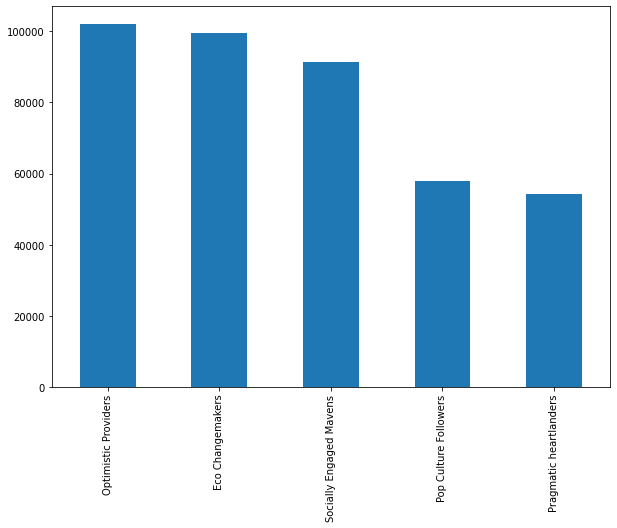

In [6]:
plt.figure(figsize=(10,7))
ig.segment_name.value_counts().plot(kind='bar');

In [7]:
# note: slower students may wish to skip this step to finish the lab in class
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

# load a list of stop words
nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string 
        return: modified initial string
    """
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincentleonardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
ig.post_caption = ig.post_caption.apply(clean_text)

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/bs4/__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://www.linkedin.com/posts/activity-6660722670109372416-wjiG" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://t.socialecommerce.shop/16MLJe" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an 

In [31]:
ig.post_caption[0]

'collin tomahawk thank anonymised_user vouchers 30 anonymised_user remaining amount'

In [9]:
ig['segment_name'].isnull().values.any()

False

In [10]:
ig['post_caption'].apply(lambda x: len(x.split(" "))).sum()

10138519

## Google Word2Vec

In [11]:
# %%time
# import gensim.downloader
# from gensim.models import Word2Vec

# wv = gensim.downloader.load('word2vec-google-news-300')
# wv.init_sims(replace=True)
# print('Model loaded')

## Own model

In [12]:
from tqdm import tqdm
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [13]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [14]:
X_train, X_test, y_train, y_test = train_test_split(ig.post_caption, ig.segment_name, random_state=0, 
                                                    test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [15]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 404834/404834 [00:00<00:00, 4136794.31it/s]


In [16]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 404834/404834 [00:00<00:00, 7227148.53it/s]


In [32]:
model_dbow.wv.most_similar(positive=['wastage'])

[('night#dnd', 0.2691865861415863),
 ('domsticay', 0.2663660943508148),
 ('#tadka', 0.2637594938278198),
 ('teenyweenytreatswixsitecom', 0.261984258890152),
 ('adalembutkan', 0.26160022616386414),
 ('#clearoutthefridge', 0.25924795866012573),
 ('brigens', 0.25315940380096436),
 ('#sgcbday23', 0.25075116753578186),
 ('jadian', 0.245031476020813),
 ('setnow', 0.24337828159332275)]

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
	"Creates and TSNE model and plots it"
	
#     fyi: to test specific labels instead of all the words in the vocab: 
#     labels = ['king', 'queen', 'prince', 'farmer', 'blue', 'red']
#     tokens = []
#     for label in labels: 
#         tokens.append(model[label])

	labels = []
	tokens = []
	

	# to speed up the process, let's limit to the first 100 elements
	count = 0
	for word in model.wv.key_to_index:
		# store the word embeddings of the words 
		tokens.append(model[word])
		# keep track of the labels too so that we can plot it in the graph below
		labels.append(word)
		# if count < 100:
		#     # store the word embeddings of the words 
		#     tokens.append(model[word])
		#     # keep track of the labels too so that we can plot it in the graph below
		#     labels.append(word)
		#     count = count+1

	# define the parameters of the tsne model
	tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
	
	# for the embeddings of our tokes to the tsne model
	new_values = tsne_model.fit_transform(tokens)


	# Now let's plot the tsne projects for each of the tokens in 2D
	x = []
	y = []
	for value in new_values:
		x.append(value[0])
		y.append(value[1])
		
	plt.figure(figsize=(16, 16)) 
	for i in range(len(x)):
		plt.scatter(x[i],y[i])
		plt.annotate(labels[i],
					 xy=(x[i], y[i]),
					 xytext=(5, 2),
					 textcoords='offset points',
					 ha='right',
					 va='bottom')
	plt.show()
	
tsne_plot(model_dbow)

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [17]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [18]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

/var/folders/x1/zp6kq1kj15v_md17wpr_q_n40000gn/T/ipykernel_20087/1408184650.py:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [19]:
train_vectors_dbow

array([[ 0.26779103, -0.14948994, -0.13801464, ..., -0.75395948,
         0.58678418, -1.11683571],
       [ 0.00538069, -0.05924345, -0.06155594, ..., -0.00664131,
         0.0573557 , -0.09703433],
       [ 0.13948938, -0.1640655 , -0.02547048, ..., -0.13120618,
         0.16027912, -0.13704248],
       ...,
       [-0.11584818, -0.05053597, -0.01060391, ..., -0.08889598,
        -0.04741215, -0.00848859],
       [-0.1152126 , -0.07835079, -0.42824656, ..., -0.02718415,
         0.33847138, -0.78064752],
       [-0.08749952, -0.12147317,  0.14379647, ..., -0.1576713 ,
         0.32114059, -0.37484062]])

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vincentleonardo/.virtualenvs/2021-11_Synthesis_Sustainability/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

accuracy 0.43336818964026647
                         precision    recall  f1-score   support

       Eco Changemakers       0.54      0.52      0.53     30058
   Optimistic Providers       0.42      0.69      0.53     30522
  Pop Culture Followers       0.31      0.13      0.19     17195
 Pragmatic heartlanders       0.29      0.07      0.11     16426
Socially Engaged Mavens       0.40      0.46      0.43     27250

               accuracy                           0.43    121451
              macro avg       0.39      0.37      0.36    121451
           weighted avg       0.41      0.43      0.40    121451

